In [1]:
# Load libraries

# # Plotting utils
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import metpy.calc as mpc
import Ngl
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter
from metpy import interpolate
from metpy.calc import vertical_velocity
from metpy.units import units
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings("ignore")

In [2]:
def preprocess_LES(ds):
    keepVars = ['XTIME','AVS_SH','AVS_LH','AVS_LWP','AVS_RAIN','AVP_QC','AVP_QV',
                'AVP_Z','AVP_P','AVP_THL','AVP_TH','AVP_LWC','AVP_IWC']
    
    dsTimes = ds.Times.load()
    
    times = []
    for iT in range(len(dsTimes.values)):
        timeNow = datetime.datetime.strptime(dsTimes.astype(str).values[iT], '%Y-%m-%d_%H:%M:%S')
        times   = np.append(times, timeNow)

    ds = ds.assign_coords({"Time": times, 
                           "west_east": (ds.west_east.load().values)*0.250,
                           "south_north": (ds.south_north.load().values)*0.250})
    
    ## Convert to local time and drop first time 
    ds['Time'] = ds['Time'].values - np.timedelta64(5, 'h') # And convert to local time by -5hrs 

#     iTimes = np.where(testDS['Time'].values >= (testDS['Time'].values[0] + np.timedelta64(1, 'h')) )[0]
#     testDS = testDS.isel(Time=iTimes)
    
    return ds[keepVars]
    # return ds[keepVars].load()


## Read in data

In [3]:
## Read in observations we have 

forcingFile  = '/glade/work/mdfowler/CLASP/clasp-htg.bdate.nc'
forcDS       = xr.open_dataset(forcingFile, decode_times=True)

## Convert to local time
localTimes  = forcDS['time'].values - np.timedelta64(5,'h')
forcDS      = forcDS.assign_coords({"time": localTimes})

## Can we get a measure of vertically integrated moisture/temperature convergence? 
g = 9.8 
vertInt_T_adv_h = np.zeros([len(forcDS.time.values)])
vertInt_Q_adv_h = np.zeros([len(forcDS.time.values)])

for iP in range(len(forcDS.lev.values)-1):
    dP = (forcDS.lev.values[iP]-forcDS.lev.values[iP+1])*100.0 # Convert from hPa to Pa

    ## Adding a negative sign outside of the advective terms - 
    ##   These are the values of T and Q divergence, so their negative is *convergence* and easier to interpret
    vertInt_Tadv_levl = dP*(-forcDS.T_adv_h.values[:,iP,0,0]/3600.0) # Convert T_adv units from K/hr to K/s
    vertInt_Qadv_levl = dP*(-forcDS.q_adv_h.values[:,iP,0,0]/3600.0) # Convert Q_adv units from g/kg/hr to g/kg/s

    # Sum over all the levels 
    vertInt_T_adv_h = vertInt_T_adv_h + vertInt_Tadv_levl
    vertInt_Q_adv_h = vertInt_Q_adv_h + vertInt_Qadv_levl

vertInt_T_adv_h = vertInt_T_adv_h/g
vertInt_Q_adv_h = vertInt_Q_adv_h/g

forcDS['vertInt_T_adv_h'] = (('time'), vertInt_T_adv_h)
forcDS['vertInt_Q_adv_h'] = (('time'), vertInt_Q_adv_h)



**Get LES data**

In [4]:
## Read in LES days in 2015 and 2016

datesTXT = '/glade/work/mdfowler/CLASP/WRFLESdateStrings.txt'

LESdates = pd.read_csv(datesTXT, sep=" ", header=None)
LESdates.columns = ['dateVal']

allYears   = [] 
allMonths  = []
allDays    = []

for iDate in range(len(LESdates.dateVal)):
    allYears   = np.append(allYears,   LESdates.dateVal.values.astype(str)[iDate][0:4]) 
    allMonths  = np.append(allMonths,  LESdates.dateVal.values.astype(str)[iDate][4:6])
    allDays    = np.append(allDays,    LESdates.dateVal.values.astype(str)[iDate][6::])



In [5]:
lesDir        = '/glade/work/mdfowler/CLASP/LESdata_fromJason/allDays_250mRes/'

## Fix time arrays to be useful in the LES cases
startTime = datetime.datetime(2016,1,1, 0,0,0)

# Empty arrays: 
dateStringsUsed   = []
circMetric_daysUsed = []
circMetric_daysUsed_defMatch = []
daysWithDefault = []
dailymax_LES_thl2 = []

## Counter for how many days have default output
numDaysDefault = 0
dayCounts = 0 

for iDay in range(len(allYears)): 
     
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    ## First: read LES data (surface thl2 and qv2) 
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    dateString = allYears[iDay]+allMonths[iDay]+allDays[iDay]
    
    if ( (int(allYears[iDay])==2015) | (int(allYears[iDay])==2016) ) :
        ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
        ## Get LES data
        ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
        HTGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_00.nc', decode_times=False)
        HMGds_allVars = xr.open_dataset(lesDir+'trimfr2_'+dateString+'_01.nc', decode_times=False)

        HTGds_allVars = HTGds_allVars.assign_coords({"case": 'HTG'})
        HMGds_allVars = HMGds_allVars.assign_coords({"case": 'HMG'})

        # LES_thl2 = xr.concat([HMGds_thl2, HTGds_thl2], "case")
        LES_allVars = xr.concat([HMGds_allVars, HTGds_allVars], "case")

        ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
        ## Also get forcing data and observations
        ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
        iDay_forcDS   = np.where( (forcDS['time.year']==int(allYears[iDay])) & 
                                  (forcDS['time.month']==int(allMonths[iDay])) & 
                                  (forcDS['time.day']==int(allDays[iDay])) )[0]
        forcDS_daySel = forcDS.isel(time=iDay_forcDS)


        ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        ## Just a few more processing steps 
        ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

        ## Get a better time dimension to use  (LES)
        times_LESday = [] 
        for iT in range(len(LES_allVars.time.values)): 
            timeStep     = startTime + timedelta(minutes = int(LES_allVars.time.values[iT])) - timedelta(hours = 5)   ## Also convert to local time 
            times_LESday = np.append(times_LESday, timeStep)

        LES_allVars['datetime'] = (('time'), times_LESday)
        LES_allVars             = LES_allVars.set_index(time='datetime')

        ## Combine into one array 
        if dayCounts==0: 
            # LES_allDays_thl2    = LES_thl2
            LES_allDays_allVars = LES_allVars
            forcDS_allDays      = forcDS_daySel
        else:
            # LES_allDays_thl2    = xr.concat([LES_allDays_thl2, LES_thl2], "time")
            LES_allDays_allVars = xr.concat([LES_allDays_allVars, LES_allVars], "time")
            forcDS_allDays      = xr.concat([forcDS_allDays, forcDS_daySel], "time") 
        dayCounts = dayCounts+1

        del LES_allVars

        print('Done with ', dateString)

Done with  20150606
Done with  20150609
Done with  20150627
Done with  20150801
Done with  20150829
Done with  20160518
Done with  20160530
Done with  20160610
Done with  20160611
Done with  20160614
Done with  20160619
Done with  20160625
Done with  20160716
Done with  20160719
Done with  20160720
Done with  20160818
Done with  20160819
Done with  20160830


In [6]:
print('Number of LES days: ', dayCounts)

Number of LES days:  18


In [7]:
## Resample the moments to be hourly (means are listed for the hour they start in; so "8a" =mean over 8a, 8:10, 8:20, etc) 
LES_allDays_allVarsHr         = LES_allDays_allVars.resample(time='1H').mean(dim='time').dropna(dim='time')
LES_allDays_allVars30m        = LES_allDays_allVars.resample(time='30Min').mean(dim='time').dropna(dim='time')

## Add thirty minutes to match the other LES output better 
LES_allDays_allVarsHr['time'] = LES_allDays_allVarsHr['time'] + np.timedelta64(30, 'm')

## For consistency with other LES files, let's also only get means through hour 21
iHrsSel               = np.where(LES_allDays_allVarsHr['time.hour'].values<22)[0]
LES_allDays_allVarsHr = LES_allDays_allVarsHr.isel(time=iHrsSel)


More LES files are available in these files: 

In [8]:
newLESdefDir = '/glade/campaign/cgd/tss/people/mdfowler/CLASP_LES_data/hydrology.cee.duke.edu/'
HTGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_00'))[0:dayCounts]
HMGdirs      = np.sort(glob.glob(newLESdefDir+'fr2_*_01'))[0:dayCounts]


for iHTG in range(len(HTGdirs)):
    filesHTG  = np.sort(glob.glob(HTGdirs[iHTG]+'/*.nc4'))
    
    htgLESnew = xr.open_mfdataset(filesHTG,  preprocess=preprocess_LES, concat_dim='Time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')

    if iHTG==0:
        HTGnew_allDays = htgLESnew
    else:
        HTGnew_allDays = xr.concat([HTGnew_allDays, htgLESnew], "Time")
    
    
for iHMG in range(len(HMGdirs)):    
    filesHMG = np.sort(glob.glob(HMGdirs[iHMG]+'/*.nc4'))

    hmgLESnew = xr.open_mfdataset(filesHMG,  preprocess=preprocess_LES, concat_dim='Time', 
                                    combine='nested', decode_times=False, 
                                    data_vars='minimal')
    
    if iHMG==0:
        HMGnew_allDays = hmgLESnew
    else:
        HMGnew_allDays = xr.concat([HMGnew_allDays, hmgLESnew], "Time")


print('Done reading in new LES cases')

HTGnew_allDays = HTGnew_allDays.assign_coords({"case": 'HTG'})
HMGnew_allDays = HMGnew_allDays.assign_coords({"case": 'HMG'})

LES_newDefault = xr.concat([HMGnew_allDays, HTGnew_allDays], "case")


Done reading in new LES cases


In [9]:
## Drop the first hour (7a) - this is just the initial state, not LES simulated 
iHrsSel        = np.where(LES_newDefault['Time.hour'].values>7)[0]
LES_newDefault = LES_newDefault.isel(Time=iHrsSel)

## LES times were recorded at the *end* of the hour, so just shift into the hour's mean they represent 
LES_newDefault['Time'] = LES_newDefault.Time - np.timedelta64(30, 'm')


## Analysis 

In [10]:
## Get mean hourly LES values too 
hrLES_newDefault = LES_newDefault.groupby('Time.hour').mean(dim='Time')
hrLES_moments    = LES_allDays_allVars.groupby('time.hour').mean(dim='time')


In [12]:
hrLES_newDefault

<xarray.Dataset>
Dimensions:      (hour: 15, case: 2, south_north: 520, west_east: 520,
                  bottom_top: 226)
Coordinates:
  * west_east    (west_east) float64 0.0 0.25 0.5 0.75 ... 129.2 129.5 129.8
  * south_north  (south_north) float64 0.0 0.25 0.5 0.75 ... 129.2 129.5 129.8
  * case         (case) <U3 'HMG' 'HTG'
  * hour         (hour) int64 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
Dimensions without coordinates: bottom_top
Data variables:
    AVS_SH       (hour, case, south_north, west_east) float32 dask.array<chunksize=(1, 1, 520, 520), meta=np.ndarray>
    AVS_LH       (hour, case, south_north, west_east) float32 dask.array<chunksize=(1, 1, 520, 520), meta=np.ndarray>
    AVS_LWP      (hour, case, south_north, west_east) float32 dask.array<chunksize=(1, 1, 520, 520), meta=np.ndarray>
    AVS_RAIN     (hour, case, south_north, west_east) float32 dask.array<chunksize=(1, 1, 520, 520), meta=np.ndarray>
    AVP_QC       (hour, case, bottom_top) float32 dask.array<chunksize=(1, 1, 226), meta=np.ndarray>
    AVP_QV       (hour, case, bottom_top) float32 dask.array<chunksize=(1, 1, 226), meta=np.ndarray>
    AVP_Z        (hour, case, bottom_top) float32 dask.array<chunksize=(1, 1, 226), meta=np.ndarray>
    AVP_P        (hour, case, bottom_top) float32 dask.array<chunksize=(1, 1, 226), meta=np.ndarray>
    AVP_THL      (hour, case, bottom_top) float32 dask.array<chunksize=(1, 1, 226), meta=np.ndarray>
    AVP_TH       (hour, case, bottom_top) float32 dask.array<chunksize=(1, 1, 226), meta=np.ndarray>
    AVP_LWC      (hour, case, bottom_top) float32 dask.array<chunksize=(1, 1, 226), meta=np.ndarray>
    AVP_IWC      (hour, case, bottom_top) float32 dask.array<chunksize=(1, 1, 226), meta=np.ndarray>
Attributes: (12/72)
    TITLE:                            OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                      2015-06-06_12:00:00
    WEST-EAST_GRID_DIMENSION:        521
    SOUTH-NORTH_GRID_DIMENSION:      521
    BOTTOM-TOP_GRID_DIMENSION:       227
    DX:                              250.0
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    history:                         Fri Aug 12 13:48:05 2022: ncks -4 -L 1 d...
    NCO:                             netCDF Operators version 4.8.0 (Homepage...

In [11]:
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook


In [12]:
## Compute rough estimate of PBLH as max of dTheta/dZ 

dTheta_dZ = np.full([len(hrLES_newDefault.hour.values), 
                     len(hrLES_newDefault.case.values), 
                     len(hrLES_newDefault.bottom_top.values)-1], np.nan)

for iLev in tqdm(range(len(hrLES_newDefault.bottom_top.values)-100)): 
    dZ     =  hrLES_newDefault.AVP_Z.isel(bottom_top = iLev+1)  - hrLES_newDefault.AVP_Z.isel(bottom_top = iLev)
    dTheta =  hrLES_newDefault.AVP_TH.isel(bottom_top = iLev+1) - hrLES_newDefault.AVP_TH.isel(bottom_top = iLev)

    dTheta_dZ[:,:,iLev+1] = (dTheta/dZ)
    

100%|██████████| 126/126 [3:49:22<00:00, 109.23s/it] 


In [24]:
np.shape(hrLES_newDefault.AVP_Z.isel(bottom_top = iLev+1))

(15, 2)

In [31]:
hrLES_newDefault.AVP_P

<xarray.DataArray 'AVP_P' (hour: 15, case: 2, bottom_top: 226)>
dask.array<transpose, shape=(15, 2, 226), dtype=float32, chunksize=(1, 1, 226), chunktype=numpy.ndarray>
Coordinates:
  * case     (case) <U3 'HMG' 'HTG'
  * hour     (hour) int64 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  pressure
    units:        Pa
    stagger:

In [24]:
# pblh = np.nanmax(dTheta_dZ, axis=2)

pblh_hPa = np.full([len(hrLES_newDefault.hour.values), len(hrLES_newDefault.case.values)], np.nan)
for iHr in range(len(hrLES_newDefault.hour.values)):
    for iCase in range(len(hrLES_newDefault.case.values)):
        iLevMax = np.where(dTheta_dZ[iHr,iCase,:] == np.nanmax(dTheta_dZ[iHr,iCase,:]) )[0]
        pblh_hPa[iHr, iCase] = hrLES_newDefault.AVP_P.isel(case=iCase,hour=iHr,bottom_top=iLevMax) * 0.01


In [22]:
print(np.shape(dTheta_dZ[5,0,:]))
print(np.shape(hrLES_newDefault.AVP_P.isel(case=0,hour=5).values[:-1] ))

(225,)
(225,)


In [30]:
iLevMax = np.where(dTheta_dZ[7,0,:] == np.nanmax(dTheta_dZ[7,0,:]) )[0]


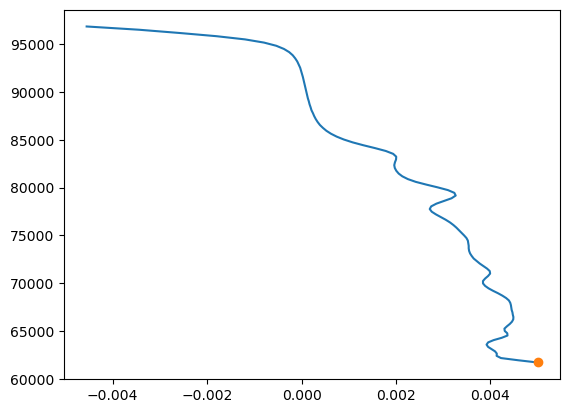

In [31]:
plt.plot(dTheta_dZ[7,0,:], hrLES_newDefault.AVP_P.isel(case=0,hour=7).values[:-1] )
plt.plot(dTheta_dZ[7,0,iLevMax], pblh_hPa[7,0]/0.01,'o')

In [13]:
import matplotlib as mpl

In [14]:
timegrid, heightgrid = np.meshgrid(hrLES_newDefault['hour'].values, hrLES_newDefault['bottom_top'].values)


In [27]:
pLevels = hrLES_newDefault.AVP_P.mean(dim='hour').mean(dim='case').values * 0.01

In [26]:
timegrid, pressgrid = np.meshgrid(hrLES_newDefault['hour'].values, pLevels)


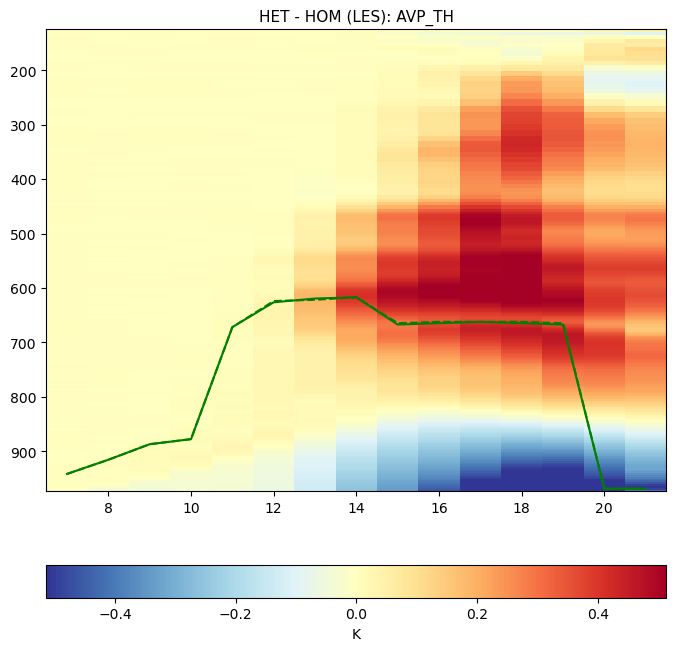

In [36]:
# varSel   = 'AVP_LWC'
# unitStr  = LES_newDefault[varSel].units
# diffDS   = (hrLES_newDefault[varSel].isel(case=1) - hrLES_newDefault[varSel].isel(case=0)).load()

varSel   = 'AVP_TH'
unitStr  = LES_newDefault[varSel].units
diffDS   = (hrLES_newDefault[varSel].isel(case=1) - hrLES_newDefault[varSel].isel(case=0)).load()

fig, ax = plt.subplots(figsize=(8,6))

## Automate choosing colorbar limits 
diffVal = np.nanmax([np.abs(np.nanmax(diffDS)), np.abs(np.nanmin(diffDS))])*0.6
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

# ax.pcolormesh(timegrid, heightgrid, np.transpose(diffDS.values), norm=diff_norm, cmap='RdYlBu_r')
ax.pcolormesh(timegrid, pressgrid, np.transpose(diffDS.values), norm=diff_norm, cmap='RdYlBu_r')

cax  = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel(unitStr)

# ax2 = ax.twinx()
ax.plot(hrLES_newDefault.hour.values, pblh_hPa[:,0],'g-')
ax.plot(hrLES_newDefault.hour.values, pblh_hPa[:,1],'g--')

ax.set_title('HET - HOM (LES): '+varSel, fontsize=11)
ax.invert_yaxis()

plt.show()